In [ ]:
import sys
from pathlib import Path
# Change path if necessary, here the cajal repository (direcotry is placed outside the online-neuro) 
sys.path.append(str(Path('../..') / 'cajal'))
sys.path.append(str(Path('..') / 'simulators'))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro.online_learning import build_model
from online_neuro.utils import CustomMinMaxScaler

from trieste.data import Dataset
from trieste.acquisition.function import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste import space

from cajal.nrn import Backend as N
from cajal.nrn.cells import MRG
from cajal.units import mm, um, mV, ms
from cajal.nrn.sources import IsotropicPoint
from cajal.units import mA, ms, ohm, cm, um
from cajal.nrn.monitors import StateMonitor, APMonitor
from cajal.nrn import SimulationEnvironment

from cajal.nrn.stimuli import MonophasicPulse

2025-02-26 09:38:38.593884: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 09:38:38.595112: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 09:38:38.600325: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 09:38:38.614457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 09:38:38.641829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

numprocs=1


In [12]:
# Set-up time resolution
N.dt = 0.005*ms #The default one

In [13]:
def create_mrg(diameter: um=27, length: mm=100, v_init: mV=-80, verbose=False):
    # Create the axon model (MRG) with specified diameter, length, and initial voltage
    mrg = MRG(diameter=diameter, length=length, v_init=v_init)

    # If verbose mode is enabled, output detailed information about the axon
    if verbose:
        # Print the total number of nodes in the axon
        print(f"Computed number of Nodes: {len(mrg.node)}")

        # Calculate and print the total axon length based on the first and last node positions
        first_node_y = mrg.node[0].y3d(0)
        last_node_y = mrg.node[-1].y3d(0)
        total_length = (last_node_y - first_node_y) / 1000
        print(f"Computed Axon Length: {total_length:.2f} mm")

        # Print the 3D coordinates of the first and last nodes
        for node, node_name in zip([mrg.node[0], mrg.node[-1]], ['first', 'last']):
            x = node.x3d(0) / 1000  # Convert from um to mm
            y = node.y3d(0) / 1000
            z = node.z3d(0) / 1000
            print(f"Node position of the {node_name} node in the axon: x={x:.2f} mm, y={y:.2f} mm, z={z:.2f} mm")

    return mrg

def plot_setup(mrg, point_sources, labels=None):
    # Extract 3D coordinates of axon nodes and convert from um to mm
    node_x = np.array([n.x3d(0) for n in mrg.node]) / 1000.0
    node_y = np.array([n.y3d(0) for n in mrg.node]) / 1000.0
    node_z = np.array([n.z3d(0) for n in mrg.node]) / 1000.0

    # Set up the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the axon as a red line in 3D space
    ax.plot(node_x, node_y, node_z, color='red', label='Axon (MRG)', linewidth=2)

    # Plot each electrode as a green marker in 3D space
    for e, point_source in enumerate(point_sources):
        x = point_source.x.value / 1000.0  # Convert from um to mm
        y = point_source.y.value / 1000.0
        z = point_source.z.value / 1000.0

        # Use provided labels or default to "Electrode"
        label = labels[e] if labels else "Electrode"
        if label == 'Stim':
            ax.scatter(x, y, z, color='green', s=80, marker='o', label=label)
        else:
            ax.scatter(x, y, z, color='red', s=80, marker='^', label=label)

    # Add axis labels
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')

    # Adjust the viewing angle for better visualization
    ax.view_init(elev=20, azim=30)

    # Add a title and legend, and show the plot
    plt.title('Axon and the Stimulation and Blocking electrode position')
    plt.legend()
    plt.show()


Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


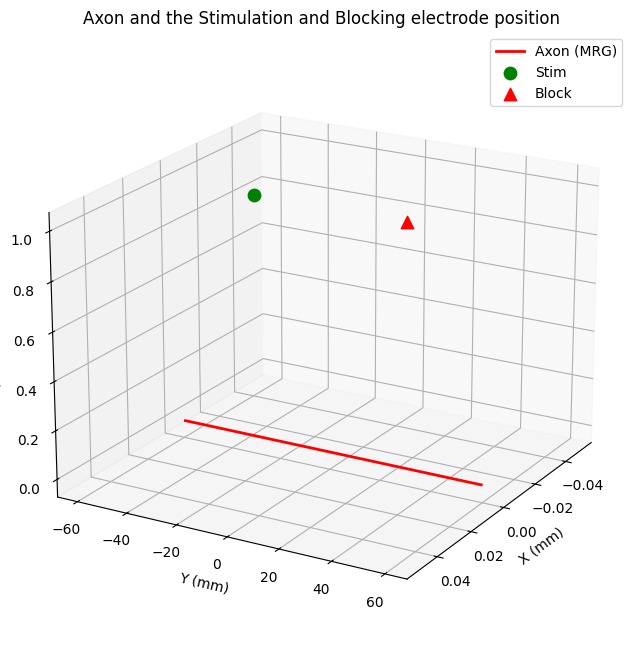

In [14]:
# Create the axon model
mrg = create_mrg(diameter=27, length=120, v_init=-80, verbose=True)

# Here we use a fixed stimulation pulse parameters that we want to block
# The stimulation pulse to block start after 2 ms
stim_amp = -1.00 #* mA
stim_pw = 0.50 #* ms
stim_delay = 2.0 #* ms

# Define blocking parameters
block_amp = 0.8 * mA 
block_pw = 0.50 * ms 
block_delay = 2.01 * ms 

# Create stimuli (a stim and block pulse)
stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

# Create electrodes at both sides of origin (spacing 60 mm) and 1 mm above the nerve
pointsource_stim = IsotropicPoint(x=0 * mm, y=-30 * mm, z=1 * mm, rhoe=500 * ohm * cm)
pointsource_block = IsotropicPoint(x=0 * mm, y=30 * mm, z=1 * mm, rhoe=500 * ohm * cm)

# Assign stimuli to electrodes
electrode_stim = pointsource_stim << stim
electrode_block = pointsource_block << block

# Set up monitors avoid monitoring the edges to eliminate boundary conditions
ap_monitor_end = APMonitor(mrg.node[-5], threshold= -20 * mV)
ap_monitor_start = APMonitor(mrg.node[5], threshold= -20 * mV)
v_rec = StateMonitor(mrg.node, "v")

# Plot the blocking
pointsources = [pointsource_stim, pointsource_block]
labels = ['Stim','Block']
plot_setup(mrg, pointsources, labels)

In [15]:
# Create the simulation environment
env = SimulationEnvironment(
    axons=[mrg],
    extra_stim=[electrode_stim,
                electrode_block], # You can leave the block out to visualize only stim
    monitors=[
        v_rec,
        ap_monitor_end,
        ap_monitor_start]
)

# Run the simulation for a sufficient duration to observe AP propagation
env.run(runtime = 6 * ms, progressbar=True, early_stopping=False)

5.5 ms: 100%|██████████| 1200/1200 [00:11<00:00, 106.08it/s]



Simulation Environment:
  # axons: 1
  # extracellular stimulating electrodes: 2
  dt: 0.005 ms

## Plotting to visualize the nerve conduction overt time and space

In [ ]:
# If you want interactive plots
%matplotlib ipympl

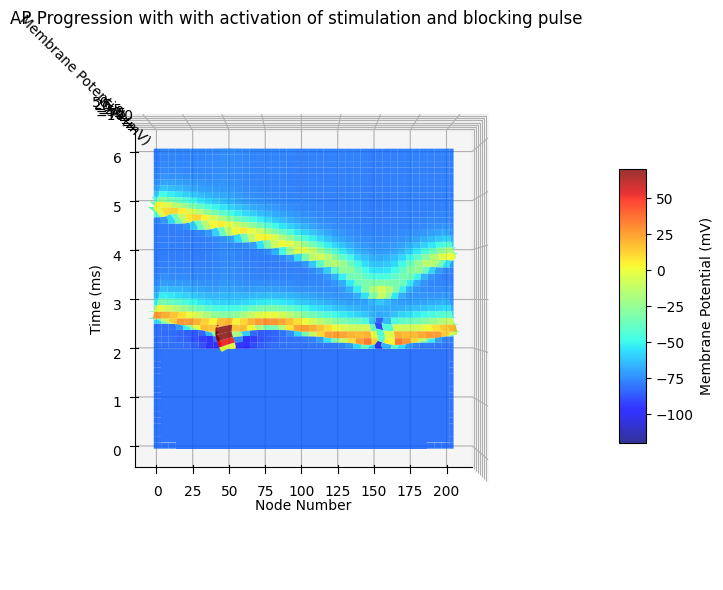

In [16]:
def plot_progression_AP_3D(mrg, v_rec):
    V = v_rec.v
    t = v_rec.t  # This gives you all time points recorded

    # Convert time to ms for plotting
    T = t / ms

    # Create meshgrids for node numbers and time steps
    nodes = np.arange(mrg.axonnodes)
    T_2D, N_2D = np.meshgrid(T, nodes, indexing='ij')  # shape (#time_steps, #nodes)
    V_t = V.T

    # Define desired membrane potential limits
    vmin = -120
    vmax = 70

    # Create a 3D figure
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(N_2D, T_2D, V_t, cmap='jet', edgecolor='none', alpha=0.8,
                           vmin=vmin, vmax=vmax)

    ax.set_zlim(vmin, vmax)
    ax.set_xlabel('Node Number')
    ax.set_ylabel('Time (ms)')
    ax.set_zlabel('Membrane Potential (mV)')
    ax.set_title('AP Progression with with activation of stimulation and blocking pulse')

    # Set the view to top-down (90-degree elevation)
    ax.view_init(elev=90, azim=-90)

    fig.colorbar(surf, shrink=0.5, aspect=10, label='Membrane Potential (mV)')

    plt.tight_layout()
    plt.show()

# An example of a failed blocking the AP prgresses to the right
plot_progression_AP_3D(mrg, v_rec)

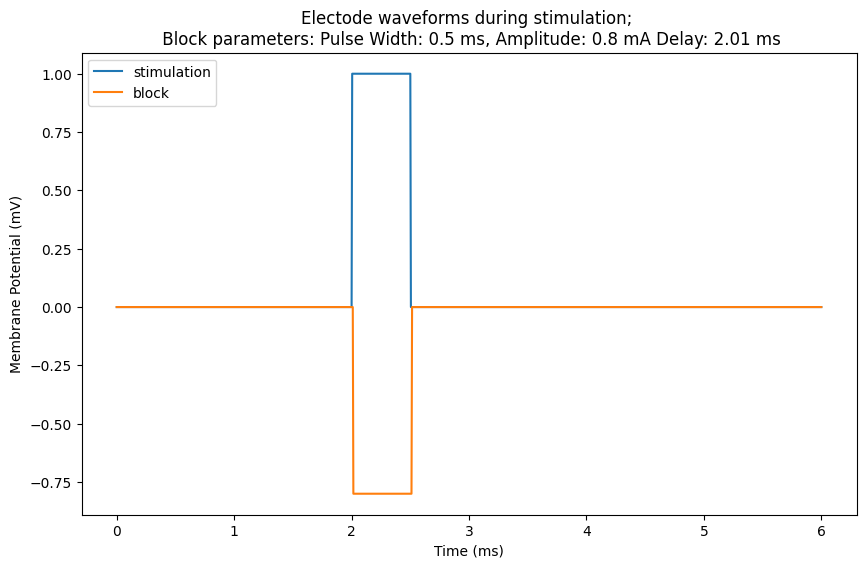

In [17]:
def plot_stim_and_block(stim, block, v_rec):  
    fig = plt.figure(figsize=(10, 6))
    t= v_rec.t 
    T = t / ms # time axes (X-as)

    plt.plot(T, -np.asarray(stim(t=v_rec.t)), label='stimulation')
    plt.plot(T, -np.asarray(block(t=v_rec.t)), label='block')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title(f'Electode waveforms during stimulation; \n Block parameters: Pulse Width: {block.pw}, Amplitude: {block.amp}' 
              f' Delay: {block.delay}')
    plt.legend(loc="upper left")

    plt.show()

plot_stim_and_block(stim, block, v_rec)

## Performing Gaussian Process based Bayesian Optimization with Online-Neuro

In [21]:
# These methods checks for action potentials (APs) on both the left and right sides.

# Blocking definition 1:
# - It verifies if APs are present in a specific time interval (2.1 ms - 2.9 ms) on the left side.
# - If an AP is detected on the right side, conduction is not blocked.
# - If no APs are found on the left side during the interval, conduction is not blocked.
# - Otherwise, conduction is considered blocked.
def nerve_block_condition(ap_monitor_left, ap_monitor_right):
    # Check if there is an AP on the left side between specific interval
    start_time_left = 2.1 * ms
    end_time_left = 2.9 * ms

    # Check the number of APs between start_time and end_time at the left side
    ap_count_left_end = ap_monitor_left.n(t=end_time_left)
    ap_count_left_start = ap_monitor_left.n(t=start_time_left)
    ap_count_left = ap_count_left_start - ap_count_left_end 
    print(f"Number of APs between {start_time_left} and {end_time_left} ms at the left side: {ap_count_left}")

    # Allow AP at the right side but not in the interval of when the stimulation pulse should arrive
    # Calculate the number of APs between start_time and end_time at the right side
    start_time_right = 1.4 * ms # don't allow blcoking because of refractory period so set start earlier
    end_time_right = 3.8 * ms

    ap_count_right_end = ap_monitor_right.n(t=end_time_right)
    ap_count_right_start = ap_monitor_right.n(t=start_time_right)
    ap_count_right = ap_count_right_start - ap_count_right_end

    ap_times_end = ap_monitor_right.spikes()
    print(f"All spike times at the right side: {ap_times_end}")
    
    if ap_count_right > 0:
        print("There is AP on the right side")
        return 1
    else:
        if ap_count_left == 0:
            print('NO AP at the left side')
            return 1
        else:
            print("AP IS BLOCKED!!")
            return 0
        
# Blocking definition 2:
# - Checks for APs at the start node in the interval.
# - If an AP is present on the right side, conduction is not blocked.
# - If no APs are present at the left start node in the interval, conduction is not blocked.
# - Otherwise, conduction is blocked.        
def nerve_block_condition_2(ap_monitor_left, ap_monitor_right):

    ap_count_right = ap_monitor_right.n(t=0 * ms)

    start_time = 2.1 * ms
    end_time = 2.9 * ms

    # Calculate the number of APs between start_time and end_time at the start node
    ap_count_left_end = ap_monitor_left.n(t=end_time)
    ap_count_left_start = ap_monitor_left.n(t=start_time)
    ap_count_left = ap_count_left_start - ap_count_left_end # Never less than zero
    print(f"Number of APs between {start_time} and {end_time} ms at start node: {ap_count_left}")

    ap_times_end = ap_monitor_right.spikes()
    print(f"All spike times at end node: {ap_times_end}")
    
    if ap_count_right > 0:
        print("There is an AP on the right side")
        return 1
    else:
        if ap_count_left == 0:
            print('NO AP at the left side')
            return 1
        else:
            print("AP IS BLOCKED!!!")
            return 0
        
# Blocking definition 3:
#  Same as defination 2 but allow an AP on the right side before stimulation 
def nerve_block_condition_3(ap_monitor_left, ap_monitor_right):
    # Allow AP at the right side only in the beginning
    ap_count_right = ap_monitor_right.n(t=1.1 * ms)

    # Check if there is an AP on the left side between specific interval
    start_time = 2.1 * ms
    end_time = 2.9 * ms

    # Calculate the number of APs between start_time and end_time at the start node
    ap_count_left_end = ap_monitor_left.n(t=end_time)
    ap_count_left_start = ap_monitor_left.n(t=start_time)
    ap_count_left = ap_count_left_start - ap_count_left_end # Never less than zero
    print(f"Number of APs between {start_time} and {end_time} ms at the left side: {ap_count_left}")

    ap_times_end = ap_monitor_right.spikes()
    print(f"All spike times at the right side: {ap_times_end}")
    
    if ap_count_right > 0:
        print("There is at least 1 AP on the right side")
        return 1
    else:
        if ap_count_left == 0:
            print('NO AP at the left side')
            return 1
        else:
            print("AP IS BLOCKED!!!")
            return 0



def run_simulation(mrg, block_amp, block_pw, block_delay):
    """
    Run the AP blocking simulation with given stimulus parameters.
    
    Parameters:
    - stim_amp_end: Amplitude of the second stimulus (mA)
    - stim_delay_end: Delay of the second stimulus (ms)
    
    Returns:
    - ap_count: Number of action potentials reaching the end of the axon.
    """

    print(f"Configuration: Amplitude {block_amp:.2f} mA, Pulse Width {block_pw:.2f} ms, Delay {block_delay:.2f}")

    # Setup a default (fixed) stimulation values 
    stim_amp = -1.00 #* mA
    stim_pw = 0.50 #* ms
    stim_delay = 2.0 #* ms

    # Create stimuli
    stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
    block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

    # Create electrodes at both ends (set spacing of 60 mm)
    pointsource_stim = IsotropicPoint(x=0 * mm, y=-30 * mm, z=1 * mm, rhoe=500 * ohm * cm)
    pointsource_block = IsotropicPoint(x=0 * mm, y=30 * mm, z=1 * mm, rhoe=500 * ohm * cm)

    # Assign stimuli to electrodes
    electrode_stim = pointsource_stim << stim
    electrode_block = pointsource_block << block

    # Set up monitors
    ap_monitor_end = APMonitor(mrg.node[-5], threshold= -20 * mV)
    ap_monitor_start = APMonitor(mrg.node[5], threshold= -20 * mV)
    v_rec = StateMonitor(mrg.node, "v")

    # Create the simulation environment
    env = SimulationEnvironment(
        axons=[mrg],
        extra_stim=[electrode_stim, electrode_block],
        monitors=[v_rec, ap_monitor_end, ap_monitor_start]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(6 * ms, early_stopping=False)

    return nerve_block_condition(ap_monitor_start, ap_monitor_end)


def nerve_conduction_blocking_objective(mrg, params):
    """
    Objective function to optimize AP blocking
    """
    
    block_amp, block_pw, block_delay = params[:, 0], params[:, 1], params[:, 2]
    
    observations = []
    
    for amp, pw, delay in zip(block_amp, block_pw, block_delay):
        # Run the simulation with given parameters
        try:
            ap_count = run_simulation(mrg, amp, pw, delay)
            observations.append(ap_count)

        except Exception as e:
            print(f"Simulation failed with amp={amp}, pulse width={pw}, delay={delay}: {e}")
            observations.append(np.nan)  

    return np.array(observations).reshape(-1, 1)


In [ ]:
# Define parameter bounds
lb = [-4.00, 0.05, 0.05]  # Lower bounds for [block_amp, block_pw, block_delay]
ub = [4.00, 3.00, 3.20]  # Upper bounds

# Initialize scaler
scaler = CustomMinMaxScaler(feature_min=lb, feature_max=ub, output_range=(-1, 1))

# Define search space
search_space = space.Box(lower=[-1, -1, -1], upper=[1, 1, 1])

# Generate initial amount of samples 
init_samples = 40
qp_minmax = search_space.sample(init_samples).numpy()
qp = scaler.inverse_transform(qp_minmax)

# Set desired diameter, length and v_init
mrg = create_mrg(diameter=27, length=120, v_init=-80, verbose=True)

# Compute obvervations of for the initial amount of samples
observations = nerve_conduction_blocking_objective(mrg, qp)

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm
Configuration: Amplitude -2.02 mA, Pulse Width 2.12 ms, Delay 1.90


5.5 ms: 100%|██████████| 1200/1200 [00:53<00:00, 22.24it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.555]
AP IS BLOCKED!!
Configuration: Amplitude 3.03 mA, Pulse Width 1.41 ms, Delay 2.16


5.5 ms: 100%|██████████| 1200/1200 [00:51<00:00, 23.42it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.37]
There is AP on the right side
Configuration: Amplitude -3.74 mA, Pulse Width 2.18 ms, Delay 3.08


5.5 ms: 100%|██████████| 1200/1200 [00:40<00:00, 29.73it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.27 5.61]
There is AP on the right side
Configuration: Amplitude -2.45 mA, Pulse Width 1.95 ms, Delay 3.13


5.5 ms: 100%|██████████| 1200/1200 [00:32<00:00, 37.00it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.255 5.445]
There is AP on the right side
Configuration: Amplitude -3.61 mA, Pulse Width 0.48 ms, Delay 2.88


5.5 ms: 100%|██████████| 1200/1200 [00:37<00:00, 31.70it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.705]
There is AP on the right side
Configuration: Amplitude 2.34 mA, Pulse Width 1.36 ms, Delay 2.71


5.5 ms: 100%|██████████| 1200/1200 [00:33<00:00, 35.54it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.93]
There is AP on the right side
Configuration: Amplitude 3.66 mA, Pulse Width 2.89 ms, Delay 1.33


5.5 ms: 100%|██████████| 1200/1200 [00:46<00:00, 25.72it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [1.53 3.18]
There is AP on the right side
Configuration: Amplitude -0.18 mA, Pulse Width 2.10 ms, Delay 0.60


5.5 ms: 100%|██████████| 1200/1200 [00:41<00:00, 28.81it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [0.985]
NO AP at the left side
Configuration: Amplitude -0.15 mA, Pulse Width 3.00 ms, Delay 0.24


5.5 ms: 100%|██████████| 1200/1200 [00:36<00:00, 33.03it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [0.64  3.825]
NO AP at the left side
Configuration: Amplitude 1.47 mA, Pulse Width 0.33 ms, Delay 2.12


5.5 ms: 100%|██████████| 1200/1200 [00:49<00:00, 24.17it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.365]
There is AP on the right side
Configuration: Amplitude 0.38 mA, Pulse Width 1.67 ms, Delay 0.72


5.5 ms: 100%|██████████| 1200/1200 [00:33<00:00, 35.68it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [1.17]
NO AP at the left side
Configuration: Amplitude 3.68 mA, Pulse Width 1.62 ms, Delay 0.39


5.5 ms: 100%|██████████| 1200/1200 [00:37<00:00, 31.67it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [0.585 3.85 ]
NO AP at the left side
Configuration: Amplitude -1.75 mA, Pulse Width 0.24 ms, Delay 1.63


5.5 ms: 100%|██████████| 1200/1200 [00:36<00:00, 32.53it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.2]
There is AP on the right side
Configuration: Amplitude 1.45 mA, Pulse Width 1.25 ms, Delay 0.31


5.5 ms: 100%|██████████| 1200/1200 [00:34<00:00, 34.95it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [0.55 3.74]
There is AP on the right side
Configuration: Amplitude -2.27 mA, Pulse Width 1.21 ms, Delay 2.35


5.5 ms: 100%|██████████| 1200/1200 [00:47<00:00, 25.13it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.91]
AP IS BLOCKED!!
Configuration: Amplitude 2.34 mA, Pulse Width 0.99 ms, Delay 0.24


5.5 ms: 100%|██████████| 1200/1200 [00:57<00:00, 20.95it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [0.455 3.68 ]
There is AP on the right side
Configuration: Amplitude 2.58 mA, Pulse Width 1.38 ms, Delay 2.79


5.5 ms: 100%|██████████| 1200/1200 [00:49<00:00, 24.39it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.005]
There is AP on the right side
Configuration: Amplitude 1.75 mA, Pulse Width 0.50 ms, Delay 0.26


5.5 ms: 100%|██████████| 1200/1200 [00:46<00:00, 25.79it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [0.495 3.675]
There is AP on the right side
Configuration: Amplitude 0.45 mA, Pulse Width 2.02 ms, Delay 3.17


5.5 ms: 100%|██████████| 1200/1200 [00:44<00:00, 26.99it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.25 5.49]
There is AP on the right side
Configuration: Amplitude -3.20 mA, Pulse Width 0.58 ms, Delay 0.46


5.5 ms: 100%|██████████| 1200/1200 [00:46<00:00, 25.67it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [1.375]
NO AP at the left side
Configuration: Amplitude 3.13 mA, Pulse Width 1.84 ms, Delay 2.03


5.5 ms: 100%|██████████| 1200/1200 [00:44<00:00, 26.96it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.235 3.975]
There is AP on the right side
Configuration: Amplitude -3.01 mA, Pulse Width 0.14 ms, Delay 1.33


5.5 ms: 100%|██████████| 1200/1200 [00:57<00:00, 20.84it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [1.85]
There is AP on the right side
Configuration: Amplitude -1.71 mA, Pulse Width 2.07 ms, Delay 2.95


5.5 ms: 100%|██████████| 1200/1200 [00:32<00:00, 36.48it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: []
AP IS BLOCKED!!
Configuration: Amplitude -0.47 mA, Pulse Width 2.12 ms, Delay 3.17


5.5 ms: 100%|██████████| 1200/1200 [00:45<00:00, 26.64it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.25]
There is AP on the right side
Configuration: Amplitude -3.93 mA, Pulse Width 0.54 ms, Delay 0.57


5.5 ms: 100%|██████████| 1200/1200 [00:33<00:00, 35.64it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [1.465]
There is AP on the right side
Configuration: Amplitude 0.64 mA, Pulse Width 1.00 ms, Delay 2.44


5.5 ms: 100%|██████████| 1200/1200 [00:30<00:00, 39.26it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.76]
There is AP on the right side
Configuration: Amplitude -3.40 mA, Pulse Width 1.76 ms, Delay 0.70


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 43.09it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.81]
There is AP on the right side
Configuration: Amplitude 0.13 mA, Pulse Width 2.93 ms, Delay 2.18


5.5 ms: 100%|██████████| 1200/1200 [00:25<00:00, 47.77it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.24]
There is AP on the right side
Configuration: Amplitude 0.60 mA, Pulse Width 1.41 ms, Delay 1.29


5.5 ms: 100%|██████████| 1200/1200 [00:30<00:00, 39.81it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [1.625]
There is AP on the right side
Configuration: Amplitude 2.98 mA, Pulse Width 2.82 ms, Delay 0.86


5.5 ms: 100%|██████████| 1200/1200 [00:29<00:00, 41.27it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [1.07  2.825]
There is AP on the right side
Configuration: Amplitude -1.39 mA, Pulse Width 0.30 ms, Delay 0.92


5.5 ms: 100%|██████████| 1200/1200 [00:24<00:00, 49.95it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [1.525]
There is AP on the right side
Configuration: Amplitude -0.91 mA, Pulse Width 0.32 ms, Delay 1.48


5.5 ms: 100%|██████████| 1200/1200 [00:39<00:00, 30.24it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.02]
There is AP on the right side
Configuration: Amplitude 3.14 mA, Pulse Width 1.36 ms, Delay 1.64


5.5 ms: 100%|██████████| 1200/1200 [00:36<00:00, 32.69it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [1.84]
There is AP on the right side
Configuration: Amplitude 0.00 mA, Pulse Width 1.57 ms, Delay 2.75


5.5 ms: 100%|██████████| 1200/1200 [00:36<00:00, 33.15it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.25]
There is AP on the right side
Configuration: Amplitude -3.43 mA, Pulse Width 0.19 ms, Delay 0.43


5.5 ms: 100%|██████████| 1200/1200 [00:33<00:00, 35.35it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [1.]
NO AP at the left side
Configuration: Amplitude -0.86 mA, Pulse Width 1.15 ms, Delay 1.23


5.5 ms: 100%|██████████| 1200/1200 [00:34<00:00, 34.70it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [1.755]
There is AP on the right side
Configuration: Amplitude 2.49 mA, Pulse Width 0.39 ms, Delay 3.17


5.5 ms: 100%|██████████| 1200/1200 [00:34<00:00, 34.77it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.245]
There is AP on the right side
Configuration: Amplitude -2.73 mA, Pulse Width 0.10 ms, Delay 2.39


5.5 ms: 100%|██████████| 1200/1200 [00:58<00:00, 20.57it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.87]
There is AP on the right side
Configuration: Amplitude -0.22 mA, Pulse Width 1.73 ms, Delay 1.19


5.5 ms: 100%|██████████| 1200/1200 [01:16<00:00, 15.59it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [1.57]
There is AP on the right side
Configuration: Amplitude -3.20 mA, Pulse Width 1.12 ms, Delay 1.91


5.5 ms: 100%|██████████| 1200/1200 [01:00<00:00, 19.73it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.375]
There is AP on the right side


In [24]:
# Create initial dataset (set query point in minmax)
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(observations, tf.float64))

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp))

# Build model
model_config = {
    'classification': True,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': True,
}

online_model = build_model(init_dataset, search_space, model_config)

# Set up acquisition function and rule
acq = BayesianActiveLearningByDisagreement()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   overwrite=True,
                                   track_path='nerve_block')

2025-02-26 11:02:18.486594: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [26]:
# Optimization loop as for a next point to query
max_iters = 40  # Increase the number of iterations as needed
iter = 0

while iter < max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')

    qp_minmax_new = ask_tell.ask_and_save().numpy()
    qp_new = scaler.inverse_transform(qp_minmax_new)

    #print(f"Configuration: amplitude {qp_new[-1, 0]:.2f} mA, pulse with {qp_new[-1, 1]:.2f} with delay {qp_new[-1, 2]:.2f} ms")

    # Run the simulation and get observations
    observations_new = nerve_conduction_blocking_objective(mrg, qp_new)

    if observations_new.ndim == 1:
        observations_new = observations_new.reshape(-1, 1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))

    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(observations_new, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
ask_tell.save()

Configuration: Amplitude -2.01 mA, Pulse Width 2.08 ms, Delay 1.98


5.5 ms: 100%|██████████| 1200/1200 [00:31<00:00, 38.14it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.57]
AP IS BLOCKED!!
Configuration: Amplitude -2.01 mA, Pulse Width 2.05 ms, Delay 2.03


5.5 ms: 100%|██████████| 1200/1200 [00:40<00:00, 29.50it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.575]
AP IS BLOCKED!!
Configuration: Amplitude -1.71 mA, Pulse Width 2.08 ms, Delay 2.93


5.5 ms: 100%|██████████| 1200/1200 [00:39<00:00, 30.39it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: []
AP IS BLOCKED!!
Configuration: Amplitude -2.01 mA, Pulse Width 2.08 ms, Delay 1.97


5.5 ms: 100%|██████████| 1200/1200 [00:37<00:00, 31.72it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.57]
AP IS BLOCKED!!
Configuration: Amplitude -2.00 mA, Pulse Width 2.06 ms, Delay 2.02


5.5 ms: 100%|██████████| 1200/1200 [00:36<00:00, 32.70it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.585]
AP IS BLOCKED!!
Configuration: Amplitude -1.96 mA, Pulse Width 1.87 ms, Delay 2.29


5.5 ms: 100%|██████████| 1200/1200 [00:31<00:00, 38.03it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.625]
AP IS BLOCKED!!
Configuration: Amplitude -1.58 mA, Pulse Width 1.11 ms, Delay 2.72


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 43.73it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.5 4.8]
There is AP on the right side
Configuration: Amplitude -2.23 mA, Pulse Width 1.32 ms, Delay 2.21


5.5 ms: 100%|██████████| 1200/1200 [00:28<00:00, 42.28it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.86]
AP IS BLOCKED!!
Configuration: Amplitude -1.88 mA, Pulse Width 2.05 ms, Delay 2.30


5.5 ms: 100%|██████████| 1200/1200 [00:33<00:00, 35.78it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.87]
AP IS BLOCKED!!
Configuration: Amplitude -1.98 mA, Pulse Width 1.95 ms, Delay 2.18


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 44.31it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.615]
AP IS BLOCKED!!
Configuration: Amplitude -1.75 mA, Pulse Width 2.77 ms, Delay 2.29


5.5 ms: 100%|██████████| 1200/1200 [00:27<00:00, 42.94it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.27 5.61]
There is AP on the right side
Configuration: Amplitude -1.98 mA, Pulse Width 1.54 ms, Delay 1.27


5.5 ms: 100%|██████████| 1200/1200 [00:26<00:00, 45.91it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.23]
There is AP on the right side
Configuration: Amplitude -1.99 mA, Pulse Width 1.97 ms, Delay 2.14


5.5 ms: 100%|██████████| 1200/1200 [00:29<00:00, 40.60it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.605]
AP IS BLOCKED!!
Configuration: Amplitude -1.89 mA, Pulse Width 2.04 ms, Delay 2.29


5.5 ms: 100%|██████████| 1200/1200 [00:24<00:00, 48.19it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.835]
AP IS BLOCKED!!
Configuration: Amplitude -2.00 mA, Pulse Width 1.95 ms, Delay 2.17


5.5 ms: 100%|██████████| 1200/1200 [00:26<00:00, 46.08it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.595]
AP IS BLOCKED!!
Configuration: Amplitude -2.03 mA, Pulse Width 1.89 ms, Delay 2.15


5.5 ms: 100%|██████████| 1200/1200 [00:25<00:00, 47.45it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.5]
AP IS BLOCKED!!
Configuration: Amplitude -2.53 mA, Pulse Width 1.92 ms, Delay 2.07


5.5 ms: 100%|██████████| 1200/1200 [00:26<00:00, 45.18it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.36]
AP IS BLOCKED!!
Configuration: Amplitude -1.34 mA, Pulse Width 1.81 ms, Delay 2.20


5.5 ms: 100%|██████████| 1200/1200 [00:17<00:00, 70.22it/s] 


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [2.975]
There is AP on the right side
Configuration: Amplitude -2.44 mA, Pulse Width 2.49 ms, Delay 2.35


5.5 ms: 100%|██████████| 1200/1200 [00:19<00:00, 62.44it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [5.235]
AP IS BLOCKED!!
Configuration: Amplitude -2.60 mA, Pulse Width 2.46 ms, Delay 1.72


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 73.92it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.57]
AP IS BLOCKED!!
Configuration: Amplitude -2.97 mA, Pulse Width 2.24 ms, Delay 2.17


5.5 ms: 100%|██████████| 1200/1200 [00:15<00:00, 77.96it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.77]
AP IS BLOCKED!!
Configuration: Amplitude -2.95 mA, Pulse Width 3.00 ms, Delay 2.04


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 71.27it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [5.43]
AP IS BLOCKED!!
Configuration: Amplitude -2.99 mA, Pulse Width 3.00 ms, Delay 1.44


5.5 ms: 100%|██████████| 1200/1200 [00:17<00:00, 70.06it/s] 


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.825]
AP IS BLOCKED!!
Configuration: Amplitude -3.60 mA, Pulse Width 3.00 ms, Delay 1.80


5.5 ms: 100%|██████████| 1200/1200 [00:18<00:00, 65.61it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [5.18]
AP IS BLOCKED!!
Configuration: Amplitude -3.78 mA, Pulse Width 3.00 ms, Delay 1.16


5.5 ms: 100%|██████████| 1200/1200 [00:14<00:00, 83.86it/s] 


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.54]
AP IS BLOCKED!!
Configuration: Amplitude -2.78 mA, Pulse Width 3.00 ms, Delay 0.81


5.5 ms: 100%|██████████| 1200/1200 [00:13<00:00, 89.05it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.19]
AP IS BLOCKED!!
Configuration: Amplitude -3.61 mA, Pulse Width 3.00 ms, Delay 0.27


5.5 ms: 100%|██████████| 1200/1200 [00:14<00:00, 83.95it/s] 


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.635]
There is AP on the right side
Configuration: Amplitude -4.00 mA, Pulse Width 3.00 ms, Delay 2.27


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 74.10it/s] 


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [5.65]
AP IS BLOCKED!!
Configuration: Amplitude -4.00 mA, Pulse Width 2.08 ms, Delay 1.71


5.5 ms: 100%|██████████| 1200/1200 [00:17<00:00, 69.61it/s] 


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.15]
AP IS BLOCKED!!
Configuration: Amplitude -3.07 mA, Pulse Width 3.00 ms, Delay 2.78


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 73.05it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: []
AP IS BLOCKED!!
Configuration: Amplitude -1.99 mA, Pulse Width 3.00 ms, Delay 1.22


5.5 ms: 100%|██████████| 1200/1200 [00:17<00:00, 68.26it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: []
AP IS BLOCKED!!
Configuration: Amplitude -4.00 mA, Pulse Width 3.00 ms, Delay 2.94


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 70.62it/s] 


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: []
AP IS BLOCKED!!


2025-02-26 11:45:01,917 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -2.53 mA, Pulse Width 3.00 ms, Delay 3.20


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 74.81it/s] 


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.25]
There is AP on the right side
Configuration: Amplitude -2.02 mA, Pulse Width 3.00 ms, Delay 0.55


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 71.54it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.945]
AP IS BLOCKED!!
Configuration: Amplitude -1.95 mA, Pulse Width 3.00 ms, Delay 0.05


5.5 ms: 100%|██████████| 1200/1200 [00:15<00:00, 75.39it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.41]
There is AP on the right side
Configuration: Amplitude -4.00 mA, Pulse Width 1.78 ms, Delay 2.37


5.5 ms: 100%|██████████| 1200/1200 [00:29<00:00, 40.58it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.51]
AP IS BLOCKED!!
Configuration: Amplitude -4.00 mA, Pulse Width 2.19 ms, Delay 1.04


5.5 ms: 100%|██████████| 1200/1200 [00:26<00:00, 44.57it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.585]
There is AP on the right side
Configuration: Amplitude -1.23 mA, Pulse Width 3.00 ms, Delay 1.16


5.5 ms: 100%|██████████| 1200/1200 [00:19<00:00, 60.86it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [1.885]
There is AP on the right side
Configuration: Amplitude -2.56 mA, Pulse Width 2.21 ms, Delay 0.86


5.5 ms: 100%|██████████| 1200/1200 [00:20<00:00, 59.24it/s]


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [3.425]
There is AP on the right side
Configuration: Amplitude -3.32 mA, Pulse Width 1.37 ms, Delay 2.66


5.5 ms: 100%|██████████| 1200/1200 [00:17<00:00, 66.69it/s] 


Number of APs between 2.1 ms and 2.9 ms ms at the left side: 1
All spike times at the right side: [4.38]
AP IS BLOCKED!!


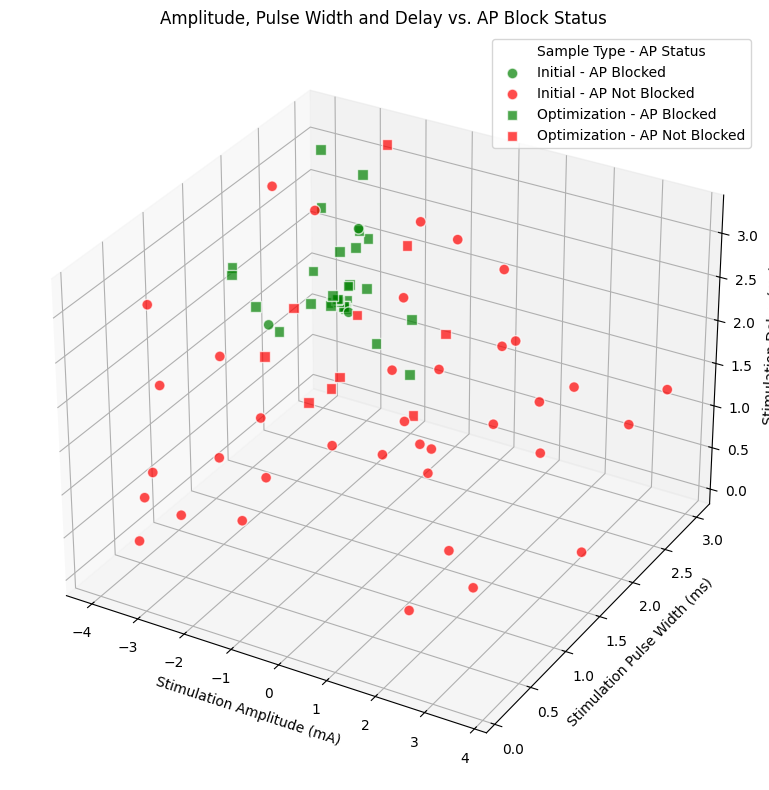

In [34]:
import pandas as pd

# Concatenate all data
all_qp_array = np.vstack(all_qp)
all_observations_array = np.vstack(all_observations).flatten()
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df = pd.DataFrame(all_qp_array, columns=['stim_amp', 'stim_pulse', 'stim_delay'])
df['ap_count'] = all_observations_array
df['sample_type'] = all_sample_types_array

# Map 'ap_count' to labels
df['ap_status'] = df['ap_count'].map({0: 'AP Blocked', 1: 'AP Not Blocked'})

# Define markers and colors
markers = {'Initial': 'o', 'Optimization': 's'}
colors = {'AP Not Blocked': 'red', 'AP Blocked': 'green'}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for sample_type in df['sample_type'].unique():
    for ap_status in df['ap_status'].unique():
        subset = df[(df['sample_type'] == sample_type) & (df['ap_status'] == ap_status)]
        if not subset.empty:
            ax.scatter(
                subset['stim_amp'],
                subset['stim_pulse'],
                subset['stim_delay'],
                c=colors[ap_status],
                marker=markers[sample_type],
                label=f"{sample_type} - {ap_status}",
                alpha=0.7,
                edgecolors='w',  # Adds white borders to markers for better visibility
                s=60  # Increases marker size for better visibility
            )

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title='Sample Type - AP Status', loc='best')

ax.set_xlabel('Stimulation Amplitude (mA)')
ax.set_ylabel('Stimulation Pulse Width (ms)')
ax.set_zlabel('Stimulation Delay (ms)')
ax.set_title('Amplitude, Pulse Width and Delay vs. AP Block Status')

plt.tight_layout()
# Save the figure
fig.savefig("AP_blocking_optimization.png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
df.sort_values(axis=0, by='ap_status').head(10)

top_blocked = df[df['ap_status'] == 'AP Blocked']
top_blocked

,stim_amp,stim_pulse,stim_delay,ap_count,sample_type,ap_status
0,-2.017642,2.124424,1.904631,0,Initial,AP Blocked
14,-2.274454,1.211154,2.353914,0,Initial,AP Blocked
22,-1.713322,2.073408,2.947255,0,Initial,AP Blocked
40,-2.011327,2.076678,1.983519,0,Optimization,AP Blocked
41,-2.006585,2.048016,2.030108,0,Optimization,AP Blocked
42,-1.707200,2.075141,2.927495,0,Optimization,AP Blocked
43,-2.011960,2.084626,1.973923,0,Optimization,AP Blocked
44,-2.000480,2.059731,2.015573,0,Optimization,AP Blocked
45,-1.959770,1.865633,2.287291,0,Optimization,AP Blocked
47,-2.233203,1.319689,2.207020,0,Optimization,AP Blocked


## Example of blocking configuration

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


5.5 ms: 100%|██████████| 1200/1200 [00:50<00:00, 23.85it/s]


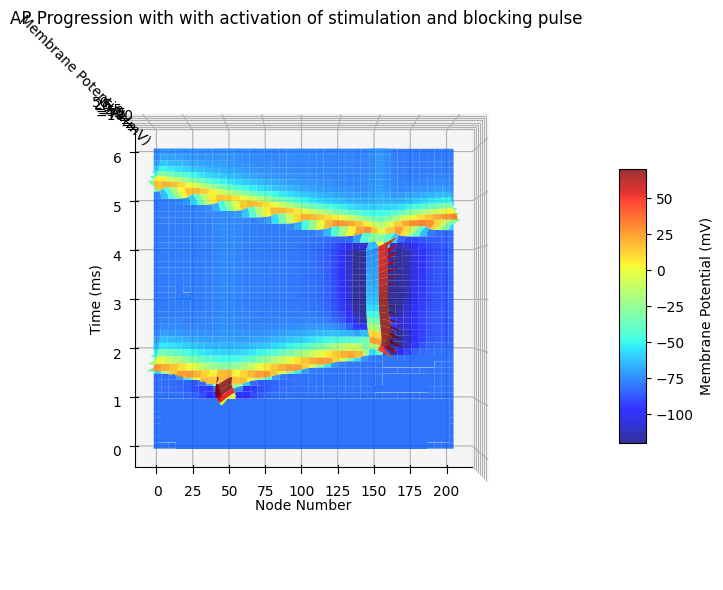

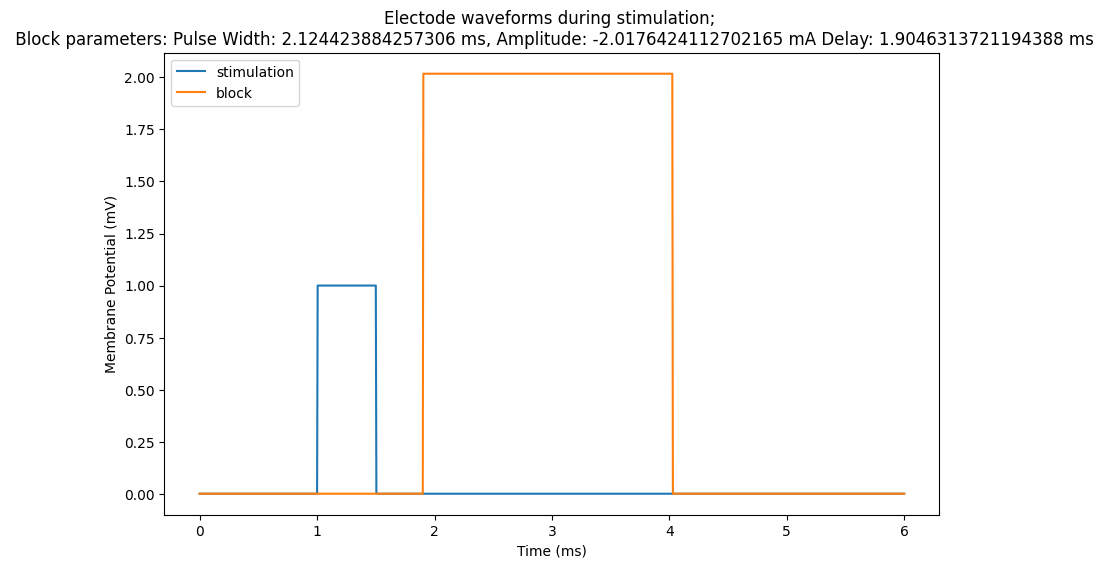

In [33]:
# Create the axon model
mrg = create_mrg(diameter=27, length=120, v_init=-80, verbose=True)

# Here we use a fixed stimulation pulse parameters that we want to block
# The stimulation pulse to block start after 1 ms
stim_amp = -1.00 #* mA
stim_pw = 0.50 #* ms
stim_delay = 1.0 #* ms

new_block_params = top_blocked.iloc[0]  # You can also use np.random.choice to pick randomly

# Assign new values for stimulation blocking
block_amp = new_block_params['stim_amp'] * mA 
block_pw = new_block_params['stim_pulse'] * ms 
block_delay = new_block_params['stim_delay'] * ms 

# Create stimuli (a stim and block pulse)
stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

# Create electrodes at both sides of origin (spacing 60 mm) and 1 mm above the nerve
pointsource_stim = IsotropicPoint(x=0 * mm, y=-30 * mm, z=1 * mm, rhoe=500 * ohm * cm)
pointsource_block = IsotropicPoint(x=0 * mm, y=30 * mm, z=1 * mm, rhoe=500 * ohm * cm)

# Assign stimuli to electrodes
electrode_stim = pointsource_stim << stim
electrode_block = pointsource_block << block

# Set up monitors avoid monitoring the edges to eliminate boundary conditions
ap_monitor_end = APMonitor(mrg.node[-5], threshold= -20 * mV)
ap_monitor_start = APMonitor(mrg.node[5], threshold= -20 * mV)
v_rec = StateMonitor(mrg.node, "v")

# Create the simulation environment
env = SimulationEnvironment(
    axons=[mrg],
    extra_stim=[electrode_stim,
                electrode_block],
    monitors=[
        v_rec,
        ap_monitor_end,
        ap_monitor_start]
)

# Run the simulation for a sufficient duration to observe AP propagation
env.run(runtime = 6 * ms, progressbar=True, early_stopping=False)

# An example of a blocking the AP prgresses
plot_progression_AP_3D(mrg, v_rec)
plot_stim_and_block(stim, block, v_rec)